# Heat Conduction in a Thin Copper Rod
To begin this exploration of numerical solutions to partial differential equations, I start by comparing numerical and analytical solutions to the heat equation in a long, one-dimensional copper rod initially at 25 $^{\circ} C$ with one end held at 100 $^{\circ} C$. It is assumed that the thermal diffusivity of copper is constant at 111 $mm^{2}/s$<sub>[1]</sub>. That is:

$$ \dfrac{\partial T}{\partial t} = \alpha \dfrac{\partial^{2} T}{\partial x^{2}}, \quad T_{0} = 100 \, ^{\circ} C, \quad T_{a} = 25 \, ^{\circ} C, \quad \alpha = 111 \, \frac{mm^{2}}{s} $$

which has the analytical solution below<sub>[2]</sub>.

$$ T(x, \, t) = \left ( T_{0} - T_{a} \right ) \left [ 1 - \text{erf} \left ( \dfrac{x}{2 \sqrt{\alpha t}} \right ) \right ] + T_{a}$$

First, the exact solution to this problem is formulated:

In [1]:
import numpy as np
from scipy.special import erf

# Parameter definitions:
T0 = 100 # (C)
Ta = 25 # (C)
alpha = 111 # (mm^2/s)

# Analytical solution definition:
def T(x, t):
    return (T0 - Ta)*(1 - erf(x/(2*np.sqrt(alpha*t)))) + Ta

### Explicit Method

Replacing partial derivatives with finite-difference approximations creates an equation that can be applied iteratively to discrete nodes along the copper rod. Note that the nature of the finite difference approximations restricts these equations to interior nodes. Superscripts denote discrete time steps and subscripts denote node number. $l$ and $i$ are the current time step and node, respectively.

$$ \dfrac{\partial T}{\partial t} \approx \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t}, \quad \dfrac{\partial^{2} T}{\partial x^{2}} \approx \dfrac{T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1}}{(\Delta x)^{2}} $$

$$ \therefore \quad \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t} = \alpha \dfrac{T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1}}{(\Delta x)^{2}} $$

A new term can be defined and the expression rearranged to solve for the temperature of a particular node at the next time step. The explicit method is named for this resulting equation which can be used to explicitly solve for future temperatures.

$$ \lambda \equiv \dfrac{\alpha (\Delta t)}{(\Delta x)^{2}} $$

$$ T^{l + 1}_{i} = T^{l}_{i} + \lambda \left ( T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1} \right ) $$

It is known $\Delta t$ must satisfy the following for the numerical solution to be convergent and stable<sub>[3]</sub>:

$$ \Delta t \leq \dfrac{(\Delta x)^{2}}{2 \alpha} $$

This numerical computation is now employed to get the PDE solution in the form of a position-time matrix.

In [2]:
# tqdm handles progress bars.
from tqdm import tqdm

# Time and space limits for the computation should be specified. However, the rod in this example is infinitely long.
t_stop = 10 # (s)
x_stop = 150 # (mm)

# Spatial and temporal steps, ensuring the time step is sufficiently small to allow convergence:
Dx = 0.1 # (mm)
Dt = (Dx**2)/(2*alpha) # (s)
lam = (alpha*Dt)/(Dx**2)

# Initial condition and boundary conditions:
num_nodes = int(x_stop/Dx)
num_time_steps = int(np.ceil(t_stop/Dt))
T_exp = Ta*np.ones((num_nodes, num_time_steps))
T_exp[0, :] = num_time_steps*[T0]

# Compute the rod temperature distribution at every time step:
for l in tqdm(range(num_time_steps - 1), desc='Preparing Explicit Numerical Solution'):
    for i in range(1, num_nodes - 1):
        T_exp[i, l + 1] = T_exp[i, l] + lam*(T_exp[i + 1, l] - 2*T_exp[i, l] + T_exp[i - 1, l])

Preparing Explicit Numerical Solution: 100%|██████████████████████████████████| 221999/221999 [11:52<00:00, 311.39it/s]


### Implicit Method

In the implicit method, spatial derivatives are taken at the next time step, $l + 1$.

$$ \dfrac{\partial T}{\partial t} \approx \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t}, \quad \dfrac{\partial^{2} T}{\partial x^{2}} \approx \dfrac{T^{l + 1}_{i + 1} - 2T^{l + 1}_{i} + T^{l + 1}_{i - 1}}{(\Delta x)^{2}} $$

$$ \therefore \quad \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t} = \alpha \dfrac{T^{l + 1}_{i + 1} - 2T^{l + 1}_{i} + T^{l + 1}_{i - 1}}{(\Delta x)^{2}} $$

Recall that $\lambda \equiv \alpha (\Delta t) \mathbin{/} (\Delta x)^{2}$. The finite difference equation can again be rearranged to obtain the following:

$$ -T^{l}_{i} - \lambda T^{l + 1}_{i + 1} + (1 + 2 \lambda) T^{l + 1}_{i} - \lambda T^{l + 1}_{i - 1} = 0 $$

The unknowns in this equation are the future temperatures, $T^{l + 1}_{i - 1}$, $T^{l + 1}_{i}$, and $T^{l + 1}_{i + 1}$. Due to initial conditions and boundary conditions, The temperature of the centered, current node, $T^{l}_{i}$, and the future temperature of the exterior nodes are known. Suppose for a moment that there are six nodes distributed over the 150 $mm$ length being considered. Then the above equation can be written for each of the four interior nodes and the resulting system represented as a matrix equation:

$$ 
\begin{pmatrix} 
(1 + 2 \lambda) & -\lambda & 0 & 0 \\
-\lambda & (1 + 2 \lambda) & -\lambda & 0 \\
0 & -\lambda & (1 + 2 \lambda) & -\lambda \\
0 & 0 & -\lambda & (1 + 2 \lambda)
\end{pmatrix} 
\begin{pmatrix} T^{l + 1}_{1} \\
T^{l + 1}_{2} \\
T^{l + 1}_{3} \\
T^{l + 1}_{4}
\end{pmatrix}
=
\begin{pmatrix}
T_{a} + \lambda T_{0} \\
T_{a} \\
T_{a} \\
(1 + \lambda) T_{a}
\end{pmatrix}
$$

Solving this system yields the temperature distribution at the time step immediately following the initial condition. Predicting the evolution of the rod's temperature with time requires solving one of these linear algebraic systems for each time step in the simulation's duration. An efficient solver of tridiagonal matrix equations can dramatically reduce this operation's computational expense. The Thomas algorithm<sub>[3]</sub> is the right tool for the job in this case. The implementation of the Thomas algorithm used here lives in `thomas_solve.py`.

In [3]:
# An efficient solver of tridiagonal matrix equations can dramatically reduce the computational expense of this implicit
# simulation. The Thomas algorithm [3] is one such solver--specifically a type of L U decomposition solver. The L U 
# decomposition of the coefficient matrix can also be reused, further improving performance. See thomas_solve.py for the
# implementation used in this simulation.
from scipy.linalg import lu
from thomas_solve import thomas_solve

# Spatial and temporal steps:
Dx = 0.01 # (mm)
Dt = 0.01 # (s)
lam = (alpha*Dt)/(Dx**2)
num_nodes = int(x_stop/Dx)
num_time_steps = int(np.ceil(t_stop/Dt))

# The coefficient matrix is reused in every future temperature computation. Notice that the number of equations in the linear
# algebraic system is the number of nodes minus the two on the rod's ends:
num_eqn = num_nodes - 2
A = (1 + 2*lam)*np.eye(num_eqn)
off_diag = (num_eqn - 1)*[-lam]
A = A + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)

# Decompose the coefficient matrix into lower and upper triangular matrices that can be reused in the Thomas algorithm.
# Diagonals from the L and U matrices are resolved for convenience.
P, L, U = lu(A)
l1 = np.diag(L, k=-1)
u0 = np.diag(U)
u1 = np.diag(U, k=1)

# The permutation matrix must be the identity matrix:
assert P.all() == np.eye(num_eqn).all()

# Initial conditions and boundary conditions are encoded in the right-hand-side vector of the above matrix equation:
b = np.array(num_eqn*[Ta])
b[0] = Ta + lam*T0
b[-1] = (1 + lam)*Ta

# Prepare the implicit method solution matrix:
T_imp = Ta*np.ones((num_nodes, num_time_steps))
T_imp[0, :] = num_time_steps*[T0]

# Iteratively solve the matrix equation Ax = b for the unknown interior temperatures and assign them to the solution matrix:
for l in tqdm(range(num_time_steps - 1), desc='Preparing Implicit Numerical Solution'):
    x = thomas_solve(l1, u0, u1, b)
    T_imp[1:-1, l] = x
    b = x
    b[0] += lam*T0
    b[-1] += lam*Ta

Preparing Implicit Numerical Solution: 100%|█████████████████████████████████████████| 999/999 [00:32<00:00, 30.64it/s]


These simulations produce a lot of data which could be reduced to make it easier to visualize. Each matrix of temperature data is cut down in the following cell to make future computations, including animation, easier.

In [4]:
# Cut down the data into more managable matrices of 1500 rows (positions) and 1000 columns (times):
num_cut_time_steps = 1000
num_cut_nodes = 1500
exp_t_inc = int(np.shape(T_exp)[1]/num_cut_time_steps)
imp_x_inc = int(np.shape(T_imp)[0]/num_cut_nodes)
T_exp = T_exp[:, ::exp_t_inc]
T_imp = T_imp[::imp_x_inc, :]

### Visualization
For the sake of efficiency in updating the animation of the temperature distribution evolving with time, function calls should be minimized. The previously-defined analytical solution to the PDE is now used to produce a matrix of data points.

In [5]:
T_exact = np.zeros((num_cut_nodes, num_cut_time_steps))
T_exact[:, 0] = [T0] + (num_cut_nodes - 1)*[Ta]
xs = np.linspace(0, x_stop, num_cut_nodes)
Dt = t_stop/num_cut_time_steps
for l in tqdm(range(1, num_cut_time_steps - 1), desc='Preparing Analytical Solution'):
    t = Dt*l
    T_exact[:, l] = T(xs, t)

Preparing Analytical Solution: 100%|██████████████████████████████████████████████| 998/998 [00:00<00:00, 10876.83it/s]


The animation below compares the analytical solution to the explicit numerically-computed solution.

<IPython.core.display.Javascript object>


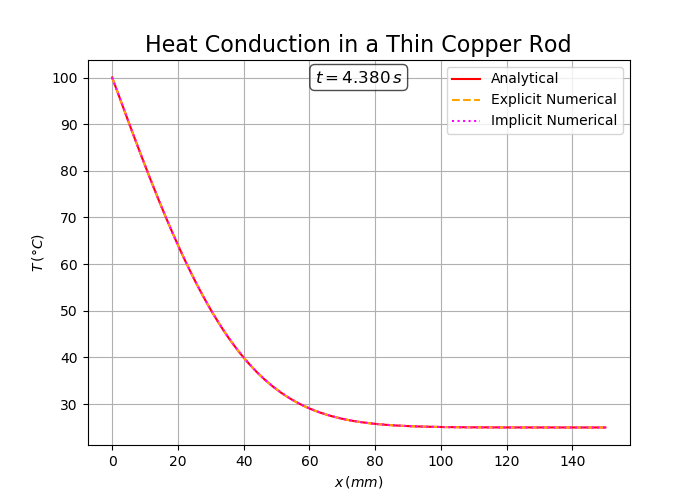

In [7]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
# Initially plot the data:
t = 0.0
fig, ax = plt.subplots(figsize=[7, 5])
ax.set_title('Heat Conduction in a Thin Copper Rod', fontsize=16)
ax.set_xlabel(r'$x \, (mm)$')
ax.set_ylabel(r'$T \, (\degree C)$')
exact_plot, = ax.plot(xs, T_exact[:, 0], color='red', linestyle='-', label='Analytical')
exp_plot, = ax.plot(xs, T_exp[:, 0], color='orange', linestyle='--', label='Explicit Numerical')
imp_plot, = ax.plot(xs, T_imp[:, 0], color='magenta', linestyle=':', label='Implicit Numerical')
t_label = ax.text(75, 100, r'$t = %.3f$' %t, bbox={'boxstyle':'round', 'facecolor':'w', 'alpha':0.7}, fontsize=12, 
                  horizontalalignment='center', verticalalignment='center')
ax.legend()
ax.grid()

# Target framerate is ~15 fps. The factor "F" is chosen such that the number of frames "f" is compatible with a delay "d"
# between frames of 67 ms (~15 fps):
D = t_stop*1000 # (ms)
d = 67 # (ms)
f = int(D/d) # (frames)
F = int(num_time_steps/f)

# Function updating the plotted data. This is called each frame of the animation.
def update(l):
    
    # Get new data:
    l *= F
    t = l*Dt
    
    # Assign the new data to the plots:
    exact_plot.set_ydata(T_exact[:, l])
    exp_plot.set_ydata(T_exp[:, l])
    imp_plot.set_ydata(T_imp[:, l])
    t_label.set_text(r'$t = %.3f \, s$' %t)

# Set up the animation:
ani = animation.FuncAnimation(fig, update, frames=f, interval=d, repeat=True)

Since the rod is infinitely long, it is legal to extend its length in the simulation. This extension becomes necessary because the numerical simulation diverges from the analytical solution if the rod is sufficiently short and/or the simulation time is sufficiently long for the far end's temperature to rise above $T_{a}$. This is because the finite difference discretization of the PDE can only be applied to interior nodes. It is appropriate that the end of the rod at $T_{0}$ remains at 100 $^{\circ} C$ because that is the Dirichlet boundary condition specified for this problem. But the rod's far end should not be restricted in this way. Perhaps this problem can be avoided by assuming the last two nodes are isothermal--a reasonable approximation if $\Delta x$ is sufficiently small or if the heat flux at the end of the rod is small.

# References
1. Thermal diffusivity. (2020, June 16). Retrieved July 08, 2020, from https://en.wikipedia.org/wiki/Thermal_diffusivity
2. Callister, W., &amp; Rethwisch, D. (2008). Diffusion. In Fundamentals of Materials Science and Engineering (3rd ed., pp. 167-168). Hoboken, NJ: Wiley.
3. Chapra, S. C., &amp; Canale, R. P. (2015). Numerical Methods for Engineers (7th ed.). New York, NY: McGraw-Hill Education.